<div dir="rtl" lang="he" xml:lang="he">


# אימון רשת סיווג תמונות _Classifier_ 
לאחר שלמדנו איך טנזורים עובדים, איך בונים רשת נויירונים ואיך מחשבים את השגיאה שלה ומעדכנים אותה. הדבר האחרון שנותר לשאול הוא 
### איך מביאים את המידע?
באופן כללי, לכל סוג מידע כמו תמונות, מוזיקה, טקסט או וידאו, יש חבילות סטנדרטיות של פייתון שמאפשרות להמיר את המידע למערך _numpy_. לאחר מכן ניתן בקלות להכניס אותם לתוך טנזור. 

- עבור תמונות יש את החבילות [Pillow](https://pillow.readthedocs.io/en/stable/), [OpenCv](https://opencv.org/) 
- עבור אודיו יש את החבילות [SciPy](https://scipy.org/), [Librosa](https://librosa.org/)
- טקסט ניתן לטעון בצורה ישירה דרך פייתון, או עם החבילות [NLTK](https://www.nltk.org/), [spaCy](https://spacy.io/) 

במיוחד עבור תמונות וראיה ממוחשבת, יש מודל בשם `torchvision` שמכיל כלים לטעינת הדאטה של מאגרי מידע _dataset_ מפורסמים, כמו [ImagNet](https://www.image-net.org/),[Cifar10](https://www.cs.toronto.edu/~kriz/cifar.html),[MNIST](http://yann.lecun.com/exdb/mnist/), וכן כלים לטיפול בתמונות. כל אלה נמצאים במודלים `torchvision.datasets` וב `torch.utils.data.DataLoader`.  

החבילות האלה נותנות לאמן מידע בנוחות גדולה, ומונעים כתיבת קוד משעמם. 


<div dir="rtl" lang="he" xml:lang="he">


במדריך הזה אנחנו נשתמש במאגר _CIFAR10_. יש לו את 10 הקטגוריות האלה: _airplane_, _automobile_ , _bird_, _cat_, _dog_, _deer_, _frog_, _horse_, _ship_, _truck_ . 

כל התמונות הם בגודל 3X32X32,
כלומר 3 צבעי היסוד על ריבועים של 
$32*32$


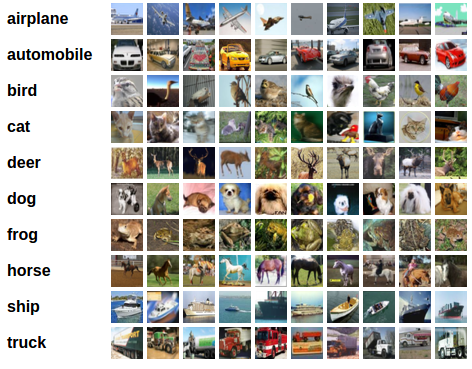

<div dir="rtl" lang="he" xml:lang="he">

## שלבים בבניית מסווג תמונות _Image classifier_
בשביל לבנות רשת לסיווג תמונות נצטרך את השלבים הבאים:
1. נטען מתוך  _CIFAR10_ את מאגר התמונות המתייוגות עלהם נתאמן _training set_ , ואת מאגר התמונות עלהם נבדוק את הרשת _test set_.
2. נגדיר רשת נויירונים מסוג רשת קונבולוציה [CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network)
3. נגדיר את פונקציית השגיאה שלנו
4. נאמן את הרשת על סט האימון
5. נבדוק עד כמה הרשת שבנינו טובה על סט המבחן


<div dir="rtl" lang="he" xml:lang="he">


### 1. טעינת התמונות 
ע"י `torchvision` ניתן לטעון בקלות את מאגר התמונות

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

<div dir="rtl" lang="he" xml:lang="he">


הקבצים שמגיעים מ`torchvision` הם תמונות מסוג
 _PILImage_
כך שכל פיקסל הוא בטווח [0,1],
אנחנו נרצה לנרמל את המידע לטווח של [-1,1]
ולהציג אותו בתור טנזור

לכן נגדיר תחילה פונקציה בשם `transform` שתמיר באופן אוטומטי את התמונות כבר בטעינה שלהם 

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

<div dir="rtl" lang="he" xml:lang="he">

נראה כמה מתמונות האימון, בשביל הכיף 



In [ ]:
it = iter(testloader)

In [ ]:
next(it)

In [42]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

# functions to show an image


def imshow(image):
    image = image / 2 + 0.5     # unnormalize
    px.imshow(image.transpose(0,2).transpose(0,1).numpy()).show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

ship  horse ship  car  


<div dir="rtl" lang="he" xml:lang="he">


### 2. הגדרת רשת נויירונים

נשתמש ברשת הנויירונים אותה הגדרנו בפרק הקודם, נשנה אותה כך שתקבל 3 ערוצים לכל תמונה. (במקום ערוץ אחד כמו שהיה לפני)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__(Net)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

<div dir="rtl" lang="he" xml:lang="he">


### 3. הגדרת פונקציית השגיאה ופונקציית האופטימיזציה 
נגדיר פונקציית שגיאה מסוג `CrossEntropyLoss` ופונקציית תיקון _SGD_ רגילה.  




In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

<div dir="rtl" lang="he" xml:lang="he">

### 4. אימון הרשת 
עכשיו הדברים מתחילים להיות מעניינים. \
נשתמש באיטרטור שמכיל את כל הדטא שלנו נעביר אותה ברשת שבנינו ובכל סיבוב נחשב את השגיאה, ולפי זה נעדכן את המשקולות של השכבות השונות. 

In [ ]:
len(trainloader)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

<div dir="rtl" lang="he" xml:lang="he">

נשמור את המודל המאומן שלנו.


[בלינק המצורף](https://pytorch.org/docs/stable/notes/serialization.html)   ניתן לראות עוד פרטים איך
_pytorch_
שומר את המודלים המאומנים. 

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

<div dir="rtl" lang="he" xml:lang="he">


##בדיקת הרשת


העברנו את הרשת פעמיים על כל הדטאסט שלנו. עלינו לבדוק האם באמת המודל מצליח לחזות יותר טוב?

נעשה ע"י מעבר על דאטאסט שלנו שמיועד לבדיקה. נבדוק כמה מתוך התמונות המודל מזהה כנכונות. 
מאוד חשוב לשים לב שאת התמונות מהדטא סט המודל לא מכיר, וזה הפעם הראשונה שהוא פוגש בהם.

נציג כמה תמונות מסט הבדיקה


In [44]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

GroundTruth:  cat   ship  ship  plane


<div dir="rtl" lang="he" xml:lang="he">

כעת נטען שוב את המודל אותו שמרנו, כאשר מאמנים מודל לא צריך לשמור ולטעון אותו שוב, פה עשיתי את זה רק בשביל ההדגמה

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<div dir="rtl" lang="he" xml:lang="he">
נראה מה המודל שלנו חושב על סט התמונות?


In [ ]:
outputs = net(images)

<div dir="rtl" lang="he" xml:lang="he">

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

ננסה להבין איזה קטגוריות הרשת הצליחה להבין בצורה קלה ואיזה לא


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# אימון הרשת על הGPU 

כמו שכתבנו בפרק הראשון, היתרון המרכזי של טנזורים הוא שאפשר להריץ אותם על הGPU וכך לקצר את זמני החישוב.
על מנת להריץ את  
Let's first define our device as the first visible cuda device if we have
CUDA available:



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_


